In [1]:
import tensorflow.keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau, ModelCheckpoint, TensorBoard

import tensorflow as tf
import os
import re
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline 

In [2]:
train_dagagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

validation_dagagen = ImageDataGenerator(rescale=1. / 255)

In [3]:
root_img_dir = 'images'
train_img_dir = os.path.join(root_img_dir,'train')
validation_img_dir = os.path.join(root_img_dir,'valid')
test_img_dir = os.path.join(root_img_dir,'pred')

# 训练集
batch_size = 16
train_generator = train_dagagen.flow_from_directory(
    train_img_dir,
    target_size=(299, 299),
    batch_size=batch_size,
    class_mode='binary'
)

# 验证集
validation_generator = validation_dagagen.flow_from_directory(
    validation_img_dir,
    target_size=(299, 299),
    batch_size=batch_size,
    class_mode='binary'
)

# 待预测集,shuffle=False防止顺序对不上
test_generator = validation_dagagen.flow_from_directory(
        test_img_dir,
        target_size=(299, 299),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

Found 19730 images belonging to 2 classes.
Found 4918 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.


In [4]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [5]:
# 设计模型
my_model = models.Sequential()
my_model.add(base_model)
my_model.add(layers.Flatten())
my_model.add(layers.Dense(1024, activation='relu'))
my_model.add(layers.Dropout(0.5))
my_model.add(layers.Dense(128, activation='relu'))
my_model.add(layers.Dropout(0.5))
my_model.add(layers.Dense(1, activation='sigmoid'))
base_model.trainable = False

my_model.compile(optimizer=tensorflow.keras.optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

print(my_model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 8, 8, 2048)        21802784  
_________________________________________________________________
flatten (Flatten)            (None, 131072)            0         
_________________________________________________________________
dense (Dense)                (None, 1024)              134218752 
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               131200    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1

In [6]:
gc.collect()

monitor = 'val_loss'
model_path = 'my_model\\my_best_weight.h5'
log_path = 'my_model\\my_log'

# LR衰减,如果在patience个epoch中看不到模型性能提升，则减少学习率
reduce_lr = ReduceLROnPlateau(monitor=monitor, factor=0.1, patience=3, verbose=1)
# 早听法，如果20轮val_loss还不下降就结束
early_stopping = EarlyStopping(monitor=monitor, patience=20, verbose=1)
# 保存最优模型
checkpoint = ModelCheckpoint(model_path, monitor=monitor, save_best_only=True, verbose=1)
#TensorBoard 可视化
tensorboard = TensorBoard(log_dir=log_path)

callbacks_list = [reduce_lr, early_stopping, checkpoint, tensorboard]
history = my_model.fit_generator(
    train_generator,
    epochs=100,
    steps_per_epoch=200,
    validation_data=validation_generator,
    validation_steps=50,
    callbacks=callbacks_list,
    verbose=2
)

Epoch 1/100

Epoch 00001: val_loss improved from inf to 0.09601, saving model to my_model\my_best_weight.h5
200/200 - 118s - loss: 0.3987 - acc: 0.8691 - val_loss: 0.0960 - val_acc: 0.9663
Epoch 2/100

Epoch 00002: val_loss did not improve from 0.09601
200/200 - 113s - loss: 0.2630 - acc: 0.9256 - val_loss: 0.1333 - val_acc: 0.9488
Epoch 3/100

Epoch 00003: val_loss improved from 0.09601 to 0.01937, saving model to my_model\my_best_weight.h5
200/200 - 115s - loss: 0.2538 - acc: 0.9369 - val_loss: 0.0194 - val_acc: 0.9912
Epoch 4/100

Epoch 00004: val_loss improved from 0.01937 to 0.01189, saving model to my_model\my_best_weight.h5
200/200 - 116s - loss: 0.2469 - acc: 0.9328 - val_loss: 0.0119 - val_acc: 0.9962
Epoch 5/100

Epoch 00005: val_loss did not improve from 0.01189
200/200 - 114s - loss: 0.2046 - acc: 0.9416 - val_loss: 0.0331 - val_acc: 0.9837
Epoch 6/100

Epoch 00006: val_loss did not improve from 0.01189
200/200 - 113s - loss: 0.1909 - acc: 0.9519 - val_loss: 0.0290 - val_ac

In [7]:
my_model.load_weights(model_path)

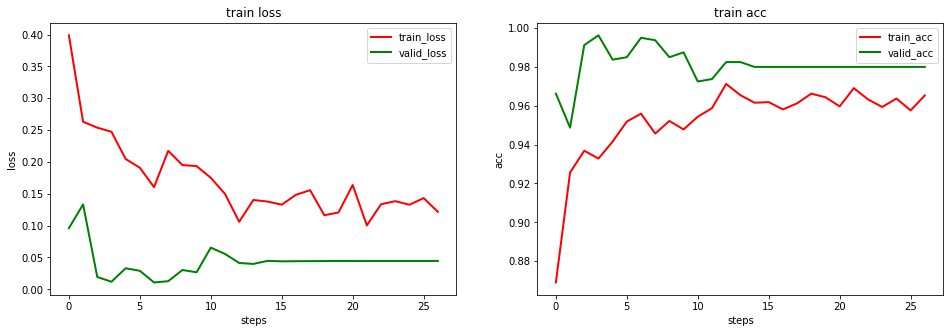

In [8]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(1,figsize=(16,5))
plt.subplot(1,2,1)
plt.plot(loss, 'r-', mec='k', label='train_loss', lw=2)
plt.plot(val_loss, 'g-', mec='k', label='valid_loss', lw=2)
plt.legend()
plt.title('train loss')
plt.xlabel('steps')
plt.ylabel('loss')

plt.subplot(1,2,2)
plt.plot(acc, 'r-', mec='k', label='train_acc', lw=2)
plt.plot(val_acc, 'g-', mec='k', label='valid_acc', lw=2)
plt.legend()
plt.title('train acc')
plt.xlabel('steps')
plt.ylabel('acc')
plt.show()

In [9]:
my_model.evaluate_generator(validation_generator, verbose=1)

308/308 [==============================] - 45s 146ms/step - loss: 0.0263 - acc: 0.9931


[0.026277751327552952, 0.99308664]

In [10]:
y_preds = my_model.predict_generator(test_generator, verbose=1)

782/782 [==============================] - 101s 129ms/step


In [11]:
pred_list = []
test_filenames = test_generator.filenames
test_preds = y_preds.clip(min=0.005, max=0.995).reshape(12500,)
for f,p in zip(test_filenames,test_preds):
    id = ''.join(re.findall(r'\d',f))
    label = p
    # print('id:{},label:{}'.format(id,label),end='\r') 
    d = {'id':id,'label':label}
    pred_list.append(d)
    
df = pd.DataFrame(pred_list)
df.sort_values(by = ["id"],inplace=True) 
df.to_csv('my_pred.csv', index=None) 
df.head(10)

,id,label
0,1,0.995000
1,10,0.005000
2,100,0.005000
3,1000,0.995000
4,10000,0.995000
5,10001,0.005000
6,10002,0.005000
7,10003,0.995000
8,10004,0.966614
9,10005,0.005000
